<a href="https://colab.research.google.com/github/sagewoodard/GEE_Sentinel2_Data/blob/main/CNN_Sentinel2_GEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install rasterio

In [2]:
# Import libraries
import ee # Google Earth Engine
import folium # Map visualization
import numpy as np # Data manipulation
from sklearn.model_selection import train_test_split # Data splitting
import tensorflow as tf # Deep learning framework
from tensorflow.keras import layers, models # CNN components
import matplotlib.pyplot as plt # Plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Evaluation method
import rasterio # GeoTIFF handling
import os # File handling

In [3]:
# Mount Google Drive and verify file location
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#file_path = '/content/drive/MyDrive/Grand_Canyon_S2_SR.tif'

#if os.path.exists(file_path):
#  print('File found:', file_path)
#else:
#  print('File not found. Check the file path.')

Mounted at /content/drive


In [4]:
# Authenticate Google Earth Engine
ee.Authenticate() # Sign in with Google account
ee.Initialize(project='satellite-data-442019') # Initialize API

*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_0JLhFqfSY1uiEaW?source=Init


In [5]:
# Data extraction from Google Earth Engine
region = ee.Geometry.Rectangle([-124.482003, 32.529521, -114.131211, 42.009518]) # Resctrict region to the California coastline
start_date = '2017-01-01'
end_date = '2023-12-31'

# Use Sentinel-2 Surface Reflectance dataset
dataset = ee.ImageCollection('COPERNICUS/S2_SR') \
  .filterDate(start_date, end_date) \
  .filterBounds(region) \
  .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)) # FIlter images with <20% cloud cover

/usr/local/lib/python3.10/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for COPERNICUS/S2_SR! You are using a deprecated asset.
To ensure continued functionality, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR

  warnings.warn(warning, category=DeprecationWarning)


In [6]:
# Inspect the filtered dataset
print("Number of images in dataset:", dataset.size().getInfo())

Number of images in dataset: 45356


In [7]:
# Mosaic and clip the dataset
mosaic = dataset.mosaic().clip(region).uint16()

# Export the data as a GeoTIFF
export_task = ee.batch.Export.image.toDrive(
    image=mosaic,
    description='California_Coast_S2_SR',
    scale=30,
    region=region.getInfo()['coordinates'],
    fileFormat='GeoTIFF'
)
export_task.start()

print('Export started. Monitor progress in Google Earth Engine Task Manager.')

# Load GeoTIFF from Google Drive
file_path = '/content/drive/MyDrive/Grand_Canyon_S2_SR.tif'
with rasterio.open(file_path) as src:
  image_data = src.read()
print('Image shape:', image_data.shape) # (bands, height, width)

Export started. Monitor progress in Google Earth Engine Task Manager.
Image shape: (23, 1831, 3725)


In [8]:
# Data preparation
# Seclect RGB bands
rgb_data = image_data[[3, 2, 1], :, :] # Red, Green, Blue
normalized_data = rgb_data / 3000.0 # Normalize pixel values

# Define patch size
patch_size = 256
patches = []

# Extract patches
for i in range(0, normalized_data.shape[1], patch_size):
  for j in range(0, normalized_data.shape[2], patch_size):
    patch = normalized_data[:, i:i+patch_size, j:j+patch_size]
    if patch.shape[1] == patch_size and patch.shape[2] == patch_size:
      patches.append(patch)

patches = np.array(patches)
patchs = np.moveaxis(patches, 1, -1) # Reshape to (num_patches, height, width, channels)
print('Patches shape:', patches.shape)

# Simulate labels
labels = np.random.randint(0, 3, len(patches))

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(patches, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Patches shape: (98, 3, 256, 256)


In [9]:
# CNN model implementation
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax') # Assuming 3 classes
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
# Reformat data from channels-first (3, 256, 256) to channels-last (256, 256, 3)
X_train = np.moveaxis(X_train, 1, -1)
X_val = np.moveaxis(X_val, 1, -1)
X_test = np.moveaxis(X_test, 1, -1)

print("Training data shape after reformatting:", X_train.shape)  # Should be (samples, 256, 256, 3)
print("Validation data shape after reformatting:", X_val.shape)
print("Test data shape after reformatting:", X_test.shape)

Training data shape after reformatting: (68, 256, 256, 3)
Validation data shape after reformatting: (15, 256, 256, 3)
Test data shape after reformatting: (15, 256, 256, 3)


In [11]:
# Training the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.4090 - loss: 9.4692 - val_accuracy: 0.4000 - val_loss: 8.9246
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3189 - loss: 10.2316 - val_accuracy: 0.3333 - val_loss: 1.8864
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3341 - loss: 2.3773 - val_accuracy: 0.4000 - val_loss: 1.1248
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3150 - loss: 1.1649 - val_accuracy: 0.2667 - val_loss: 1.5337
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4818 - loss: 1.2343 - val_accuracy: 0.2667 - val_loss: 1.2098
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2509 - loss: 1.1560 - val_accuracy: 0.4000 - val_loss: 1.1600
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.4267 - loss: 1.0832 - val_accuracy: 0.2667 - val_loss: 1.6121
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5524 - loss: 0.9062 - val_accuracy: 0.4000 - val_loss: 1.1722
E

In [12]:
# Model evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy:.2f}')

# Save the model
model.save('/content/drive/My Drive/terrain_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4000 - loss: 1.7428


Test accuracy: 0.40


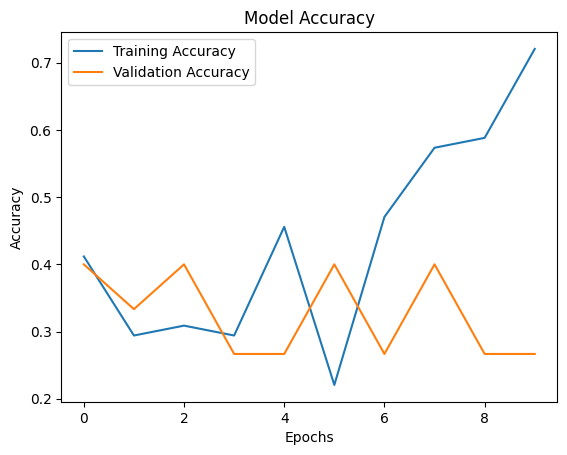

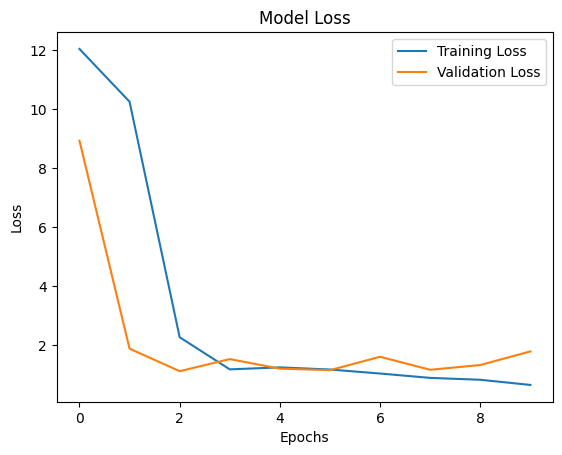

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step


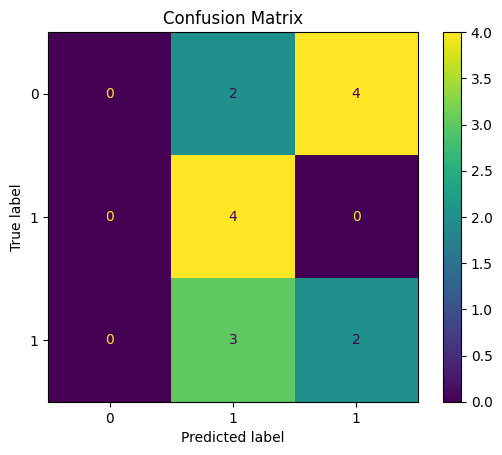

In [13]:
# Training visualization
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

# Confusion matrix
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
cm = confusion_matrix(y_test, predicted_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 1])
disp.plot(cmap='viridis')
plt.title('Confusion Matrix')
plt.show()